## Run this notebook in Google Colab by clicking here: [Google Colab](https://colab.research.google.com/github/AaronDJohnson/15yr_stochastic_analysis/blob/master/tutorials/explore_data.ipynb)

### Run these cells if using Colab. Otherwise, skip them!

In [ ]:
# This cell will reset the kernel.
# Run this cell, wait until it's done, then run the next.
!pip install -q condacolab
import condacolab
condacolab.install_mambaforge()

In [ ]:
%%capture
!mamba install -y -c conda-forge enterprise_extensions la_forge
!git clone https://github.com/AaronDJohnson/15yr_stochastic_analysis
import sys
sys.path.insert(0,'/content/15yr_stochastic_analysis/tutorials')

# Exploring NANOGrav Data

  * In this tutorial, you will learn what information exists in the data used by the NANOGrav data working group to search for gravitational waves with pulsar timing data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, json, bz2, glob
from enterprise.pulsar import Pulsar

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    datadir = '/content/15yr_stochastic_analysis/tutorials/data'
else:
    datadir = './data'

## Pulsar timing data
  `TEMPO`, `TEMPO2` and `PINT` are packages written in various programming languages used to account for every pulse that arrives at the radio telescope for the entire span of the data set.

  These packages require:
  * Files that contain information about the orientation of Earth at each pulse time
  * An ephemeris to show the location and movement of solar system objects
  * Location of observatories where radio telescopes exist to record pulse times of arrival (TOAs)
  * Clock files that contain corrections at each observatory necessary for accurate timing
  

### `.tim` files

`.tim` files contain the pulse TOAs.

Let's look at an example of a TOA

In [ ]:
# 54925.000019.3.000.000.15y.x.ff 424.000000 54925.4273452967968982 1.331 arecibo  -format Tempo2 -fe 430 -be ASP -f 430_ASP -bw 4 -tobs 903.18 -tmplt B1855+09.430.PUPPI.15y.x.sum.sm -gof 1.02 -nbin 2048 -nch 1 -chan 1 -subint 0 -snr 132.02 -wt 0.32763 -flux 30.5225 -fluxe 0.23 -proc 15y -pta NANOGrav -ver 2021.08.25-9d8d617 -to -0.789e-6 -pout_gibbs 0.014346652898292228 -pn -11489121533.0

This line gives several bits of information separated by spaces
* `-format` indicates the file format, this is a `TEMPO2` style format for the `.tim` file
* File name or identifier
* Observing frequency (MHz)
* Pulse site arrival time (MJD)
* Uncertainty on arrival time (microseconds)
* Observing site

The rest of the pieces are flags that denote receiver and backend, SNR, and other information that might be useful.

If a line starts with a `C`, it has been commented and therefore removed from the used data (perhaps as an outlier or of poor data quality)

### `.par` files
  * `.par` files contain parameters that specify the best fit parameters for the timing model
  * A timing model includes the parameters describing the motion of the system.

  For example, let's look at a few lines from `B1855+09`


In [ ]:
# PSR                              B1855+09
# EPHEM                               DE440
# CLOCK                        TT(BIPM2019)
# UNITS                                 TDB
# START              53358.7274717181849422
# FINISH             59051.1649493688614583
# INFO                                   -f
# TIMEEPH                              FB90
# T2CMETHOD                        IAU2000B
# DILATEFREQ                              N
# DMDATA                                  N
# NTOA                                 7758
# CHI2                    7639.034095518926
# ELONG                 286.863485782621126 1 0.00000000840431281622
# ELAT                   32.321482985635249 1 0.00000001322070250165
# PMELONG                -3.270863925556763 1 0.006266849685681422
# PMELAT                 -5.064266016156972 1 0.013003509741918317
# PX                     0.7453058287821062 1 0.10637238114218932
# ECL                              IERS2010
# POSEPOCH           56205.0000000000000000
# F0                  186.49408120500812819 1 1.3944100886341109293e-13
# F1               -6.20475642048559727e-16 1 9.673210162610794096e-21
# PEPOCH             56205.0000000000000000
# CORRECT_TROPOSPHERE                         Y
# PLANET_SHAPIRO                          Y
# NE_SW                                 0.0
# SWM                                   0.0
# DM                  13.311325627240166614
# DM1                                   0.0
# DMEPOCH            56205.0000000000000000
# DMX                                   0.5
# DMX_0001           -0.0022928570527114465 1 0.0014987722494377138
# DMXR1_0001         53358.6774717178704975

# ...  (more DMX lines)

# DMXR2_0147         59051.2149493685501505
# BINARY ELL1
# PB                  12.327171191603620594 1 1.1537154953313714371e-10
# A1                      9.230780019028435 1 1.5541255434261364e-07
# M2                     0.2617547606873994 1 0.008579723844358919
# SINI                   0.9989329452183565 1 0.00018476656063230824
# TASC               56211.0879673686042146 1 1.3418517503626413707e-08
# EPS1            -2.1550794535120351909e-05 1 1.6953842799307365601e-08
# EPS2             2.439461246121794172e-06 1 1.1374807628514013377e-08
# FD1                0.00011146578515037641 1 1.4431328296027875e-05
# FD2               -0.00012657919940061013 1 1.7564647114553057e-05
# FD3                 6.827289006524973e-05 1 1.0589291617380193e-05
# TZRMJD             55638.4592009703210532
# TZRSITE                                AO
# TZRFRQ                             1410.0
# JUMP            -fe L-wide   -1.7170504954499434e-05 1 4.083841525492636e-06
# EFAC            -f 430_ASP        1.1159353068139823
# EQUAD           -f 430_ASP      0.027279453727424813
# EFAC            -f 430_PUPPI        1.0000490370856534
# EQUAD           -f 430_PUPPI        0.2675837825034984
# EFAC            -f L-wide_ASP        1.0431140172703746
# EQUAD           -f L-wide_ASP        0.3034380811411345
# EFAC            -f L-wide_PUPPI         1.111843233288208
# EQUAD           -f L-wide_PUPPI       0.01755481348317892
# ECORR           -f 430_ASP       0.15917611234225237
# ECORR           -f 430_PUPPI        2.0002928648712492
# ECORR           -f L-wide_ASP        0.7577795668580285
# ECORR           -f L-wide_PUPPI       0.22820864029073645
# RNAMP                0.033219857295750374
# RNIDX                  -3.684321334617665

This file contains a lot of information about the model for B1855+09.

* The first line contains the pulsar's name: B1855+09
* Next, the name of the ephemeris and clock file are listed
* Then several bits of information ending with NTOA (the number of TOAs)
* The timing model parameters, then the DMX values which fit dispersion caused by stuff between us and the pulsars
* More timing model parameters, and starting with EFAC, we have the values from the single pulsar noise run

## `enterprise` Pulsar objects

`enterprise` can use these files to make `Pulsar` objects. These contain much of the information that the `par` and `tim` files do. More importantly for our purposes, `Pulsar` objects can be used to search for gravitational waves!

The next two cells do the same thing: load `Pulsar` objects. The first cell uses `par` and `tim` files along with a specified clock file and ephemeris to create a `Pulsar` object.

Because `Pulsar` objects can take so long to load, we packaged compressed `pickle` files with this tutorial. Your own pickle files can be made instead if you wish.

In [2]:
# Use par and tim files to load a Pulsar object
parfiles = sorted(glob.glob(datadir + '/par/*.nb.par'))
timfiles = sorted(glob.glob(datadir + '/tim/*.nb.tim'))

parfiles = [parfiles[0]]
timfiles = [timfiles[0]]

psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem='DE440', timing_package='PINT')
    psrs.append(psr)

2023-05-24 22:43:19.608 | DEBUG    | pint.toa:get_TOAs:201 - Using CLOCK = BIPM2019 from the given model
2023-05-24 22:43:21.434 | DEBUG    | pint.toa:apply_clock_corrections:2132 - Applying clock corrections (include_gps = True, include_bipm = True)
2023-05-24 22:43:21.748 | INFO     | pint.observatory:gps_correction:217 - Applying GPS to UTC clock correction (~few nanoseconds)
2023-05-24 22:43:21.749 | INFO     | pint.observatory:_load_gps_clock:94 - Loading global GPS clock file
2023-05-24 22:43:21.752 | DEBUG    | pint.observatory.clock_file:__init__:803 - Global clock file gps2utc.clk saving kwargs={'bogus_last_correction': False, 'valid_beyond_ends': False}
2023-05-24 22:43:21.755 | DEBUG    | pint.observatory.clock_file:read_tempo2_clock_file:460 - Loading TEMPO2-format observatory clock correction file gps2utc.clk (/Users/aaron/.astropy/cache/download/url/d3c81b5766f4bfb84e65504c8a453085/contents) with bogus_last_correction=False
2023-05-24 22:43:21.776 | INFO     | pint.observ

In [3]:
psrs = []
for psrfile in glob.glob('./data/jar/*.pkl'):
    with bz2.BZ2File(psrfile, 'rb') as f:
        psr = pickle.load(f)
        psrs.append(psr)

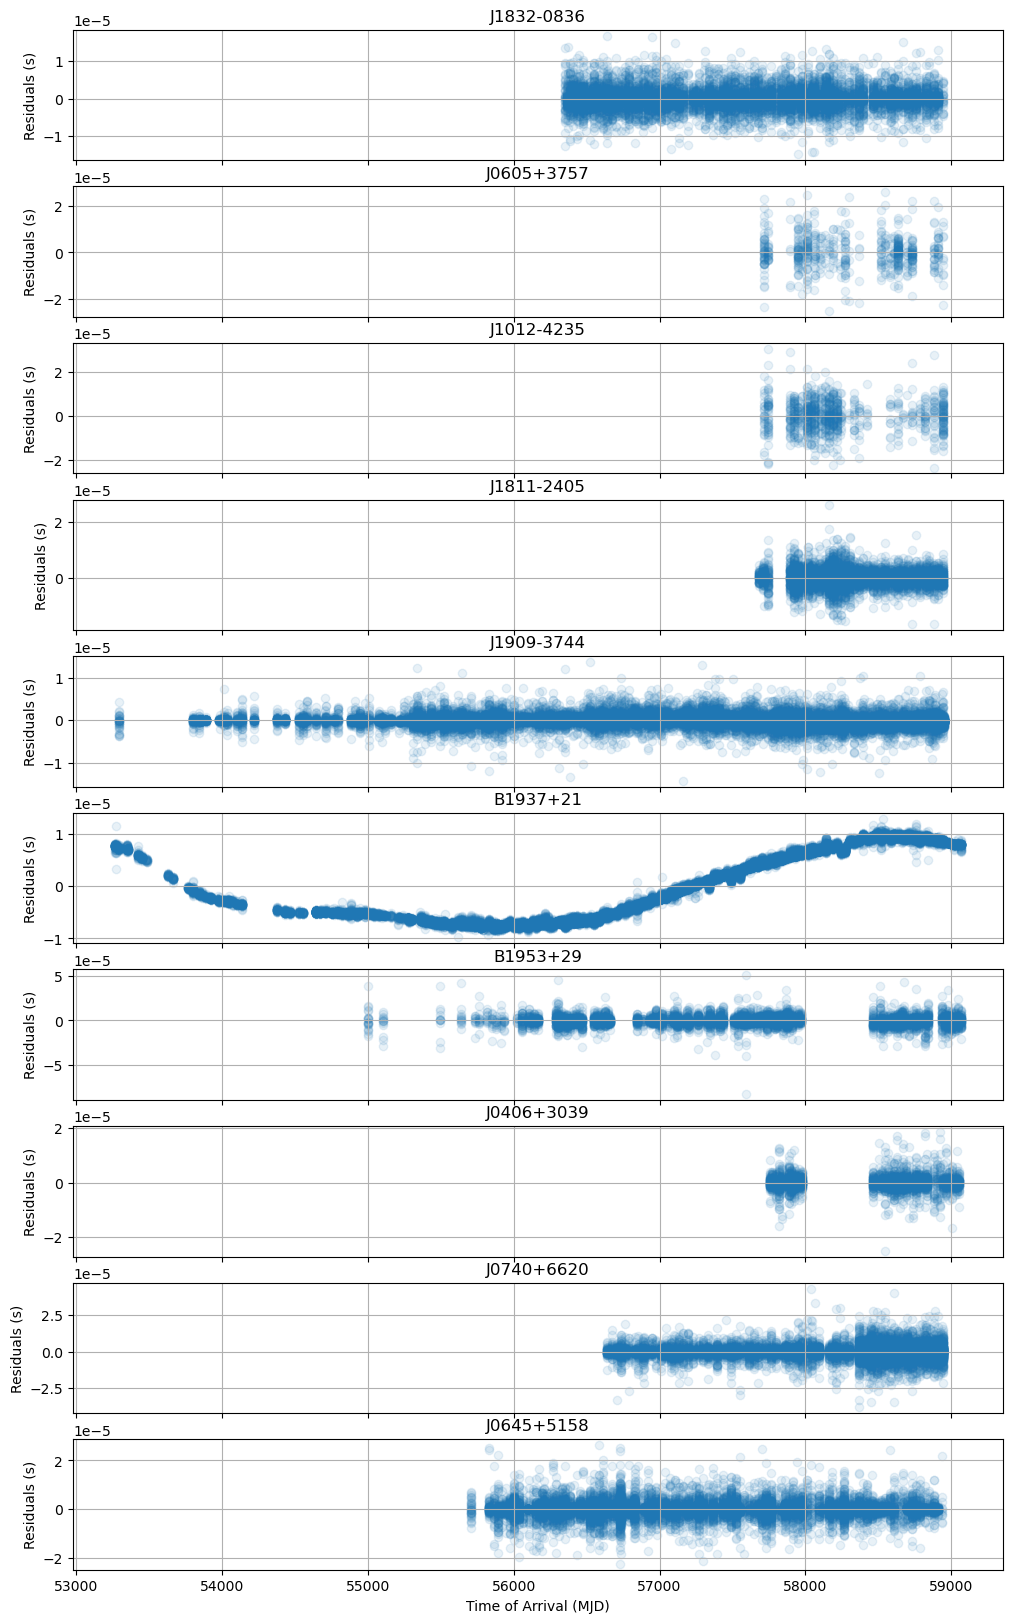

In [6]:
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(12, 20), sharex=True)
for ii in range(len(ax)):
    ax[ii].set_ylabel('Residuals (s)')
    ax[ii].set_title(psrs[ii * 2].name)
    ax[ii].scatter(psrs[ii * 2].toas / 86400, psrs[ii * 2].residuals, alpha=0.1)
    ax[-1].set_xlabel('Time of Arrival (MJD)')
    ax[ii].grid(visible=True)
plt.savefig('residuals.png', bbox_inches='tight', dpi=300)
plt.show()

* Here we have plotted the residuals for 10 different pulsars in the 15 year data set
* The total observation time span is different for each of the pulsars shown here
* Many of these pulsars have gaps in their data and are sampled unevenly
* For this reason **we do not work in the frequency domain when we search for gravitational waves**

* Next, we use `vars()` to print a dictionary of some attributes of a Pulsar object
* This should show us some of the data stored in the object
* There is a lot of output here, so uncomment the line if you wish to see what exists in the object

In [7]:
# vars(psrs[0])

* The pulsar's name is under `name`
* We also find the residuals,
* TOA errors,
* timing model design matrix (it holds the timing model for this particular pulsar)
* among many other quantities.

We now turn to the noise dictionary to see what exists in the `15yr_wn_dict.json` file.

In [5]:
with open(datadir + '/15yr_wn_dict.json', 'r') as f:
    noisedict = json.load(f)

In [6]:
for key in noisedict.keys():
    if 'B1855+09' in key:
        print(key, '=', noisedict[key])

B1855+09_430_ASP_efac = 1.115935306813982
B1855+09_430_ASP_log10_t2equad = -7.564164330699591
B1855+09_430_PUPPI_efac = 1.000049037085653
B1855+09_430_PUPPI_log10_t2equad = -6.572540211467256
B1855+09_L-wide_ASP_efac = 1.043114017270374
B1855+09_L-wide_ASP_log10_t2equad = -6.517929916655293
B1855+09_L-wide_PUPPI_efac = 1.1118432332882
B1855+09_L-wide_PUPPI_log10_t2equad = -7.755603780476984
B1855+09_430_ASP_log10_ecorr = -6.798122106550257
B1855+09_430_PUPPI_log10_ecorr = -5.6989064141929715
B1855+09_L-wide_ASP_log10_ecorr = -6.120457109433745
B1855+09_L-wide_PUPPI_log10_ecorr = -6.641667916624413
B1855+09_red_noise_log10_A = -13.940953818371378
B1855+09_red_noise_gamma = -3.68432133461766


* For example, we are showing the values for B1855+09, a single pulsar
* This file contains the maximum posterior value for white noise parameters from single pulsar noise analyses
* We use these in the full analysis to reduce the number of parameters from ~600 to ~130.

* In this tutorial we have briefly discussed some of the data files that NANOGrav uses in its search for an isotropic gravitational wave background.
* `.par` and `.tim` files are given to `enterprise` to instantiate a `Pulsar` class object
* The `Pulsar` class contains several pieces of information that `enterprise` needs to run.